In [1]:
from copy import deepcopy
from decimal import Decimal
import math
import os

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci

# Progress

1. Download files **<span style="color:black; background-color: yellow">DONE</span>**.
2. ir band: **<span style="color:aquamarine; background-color: black">IN PROGRESS</span>**.<br />
    a) no contrast enhancement DONE <br />
    b) linear stretch DEBUGGING<br />
    c) histogram equalization IN PROG
    
    What do you see in ocean areas?
    Compare two histogram images
    
3. Use appropriate bands and contrast enhancement to make natural looking RGB image **<span style="color:aquamarine; background-color: black">IN PROGRESS</span>**.<br />
    Why does image look blue without hist equalization?<br />
    Combine processed RGB images into single img using `cat` command, and plot them with `imshow()`
    
4. band1: **<span style="color:aquamarine; background-color: black">IN PROGRESS</span>**.<br />
    a) image smoothing <br />
    b) image sharpening <br />
    c) southwest illumianation (Sobel) grayscale <br />
    
5. Vegetation index **<span style="color:black; background-color: yellow">DONE</span>**.

6. EC: For extra credit, follow the methods in Rees (374-380) to decompose the 7 bands into their principal com- ponents.

# Exercise 1

Download individual files for the 7 bands of a Landsat image of San Diego, acquired in August 1990 (*.raw files). DONE



The spectral range and other file characteristics are provided in the NLAPS header file (See Appendix A of image processing notes.) Here is a summary of the spectral bands.

|band #|min (μm)   |center (μm)| color       | 
|------|-----------|-----------|-------------|
|  1   |  0.45     |   0.485   |  Blue-Green | 
|  2   |  0.52     |    0.56   |  Green      | 
|  3   |  0.63     |    0.66   |  Red        | 
|  4   |  0.76     |    0.83   |  Near-IR    | 
|  5   |  1.55     |    1.65   |  Mid-IR     | 
|  6   |  10.40    |    11.45  |  Thermal-IR | 
|  7   |  2.08     |    2.255  |  Mid-IR     | 

#### <center>Table 2.1: Landsat Spectral Bands

# Exercise 2
Display the thermal infrared band three ways: 

a) no contrast enhancement;
    original image

b) linear stretch; 
    linear strech is a special case of contrast modifiction in which transfer function mapping the original pixel range to new range is a constant gradient (i.e. scalar/number)
    effect: expand the range of pixel values
    
c) histogram equalization. 

Display results as grayscale. 

### Q: What do you see in the ocean areas? 

Compare the original image histogram with the equalized image histogram (use imhist() to display histograms).

In [2]:
# check raw files are in landsat_data directory
# os.listdir("./landsat_data")

### Read all the 7 bands

In [91]:
"""
Adopted from the matlab version given in lab5start.m
# ir = fread( fopen( 'band6c.raw', 'r'), [1500 1500], '*uint8')';

-> read the binary files (*.raw)
-> reshape to 1500 by 1500 2D-array (given)
-> dtype is unsigned integer 
"""
b1 = np.reshape(np.fromfile('./landsat_data/band1c.raw', dtype='uint8'), (1500, 1500))
b2 = np.reshape(np.fromfile('./landsat_data/band2c.raw', dtype='uint8'), (1500, 1500))
b3 = np.reshape(np.fromfile('./landsat_data/band3c.raw', dtype='uint8'), (1500, 1500))
b4 = np.reshape(np.fromfile('./landsat_data/band4c.raw', dtype='uint8'), (1500, 1500))
b5 = np.reshape(np.fromfile('./landsat_data/band5c.raw', dtype='uint8'), (1500, 1500))
b6 = np.reshape(np.fromfile('./landsat_data/band6c.raw', dtype='uint8'), (1500, 1500))
b7 = np.reshape(np.fromfile('./landsat_data/band7c.raw', dtype='uint8'), (1500, 1500))

In [4]:
# band 6 is the thermal infrared
# create deepcopy of band 6 to use same variable name,'ir', as 
# Professor Sandwell's matlab example
ir = deepcopy(b6)

## 2b) Linear Stretch

Find minimum and maximum pixel in the given data (*data6*) and map the orignal range to use
a full pixel spectrum. This will increase used pixel range and image contrast.

original pixel range: $[min_{orig}, min_{orig}]$ <br />
new (full) pixel range: $[min_{new}, max_{new}]$, usually [0, 255]


### Eqn 2b. Linear Stretch Equation 
\begin{equation*}
pixel_{out} = (pixel_{in} - min_{orig}) \frac{max_{new} - min_{new}}{max_{orig} - min_{orig}} + min_{new}
\end{equation*}

Reference: http://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm


In [5]:
def transform_linear_stretch(data):
    """
    data [String] data is original numpy array of pixels
    
    Return: output is modified, linearly streched data according to Eqn 2b.
    """
    min_orig = np.amin(data) # Minimum of the flattened array (original)
    max_orig = np.amax(data) # Maximum of the flattened array (original)
    min_new = 0
    max_new = 255
    
    # define linear stretch transformation function
    linear_stretcher = lambda pixel_orig: ((pixel_orig - min_orig)*(
        (max_new - min_new) / (max_orig - min_orig))) + min_new
    
    # Reference: http://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array
    v_linear_stretcher = np.vectorize(linear_stretcher) # vectorizing
    return v_linear_stretcher(data)

In [87]:
# linearly stretched version
ir_lin_stretch = transform_linear_stretch(ir)
np.amax(ir_lin_stretch)
np.amin(ir_lin_stretch)

0

In [8]:
print np.amax(ir)
print np.amin(ir)

195
104


In [11]:
def plot_band_graysc(_plt, subplot_num, _data, title):
    """ Plot the given band (data) in grayscale
    
    subplot_num (int): desginate the subplot location
    data (numpy array)
    title (string): plot title
    """
    _plt.subplot(subplot_num)
    _plt.imshow(_data, cmap=plt.cm.gray)
    _plt.title(title, fontsize=16) 

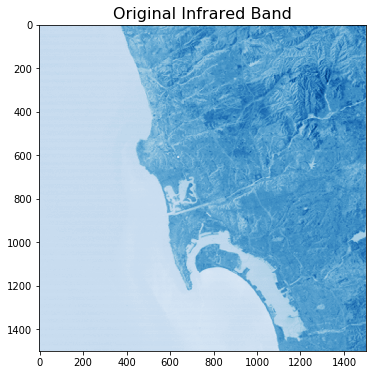

In [85]:
plt.figure(figsize=(16,6))

plt.imshow(ir, cmap = plt.cm.Blues)
plt.title('Original Infrared Band', fontsize=16)

plt.show()

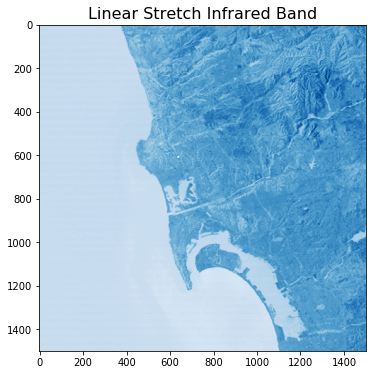

In [86]:
plt.figure(figsize=(16,6))
plt.imshow(ir_lin_stretch, cmap =plt.cm.Blues)
plt.title('Linear Stretch Infrared Band', fontsize=16)
plt.show()

## 2c) Histogram Equalization




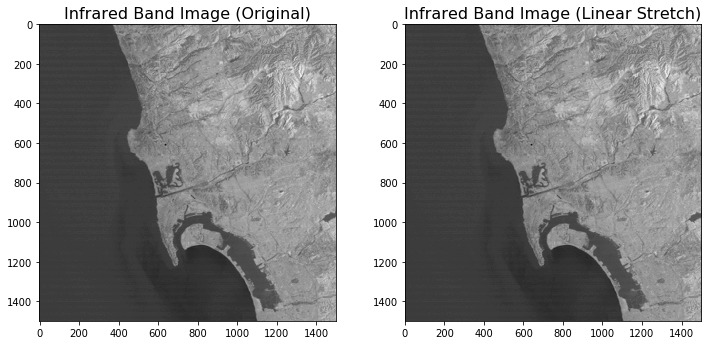

In [77]:
# b) linear stretch
plt.figure(figsize=(12,12))

# a) no contrast enhancement
plot_band_graysc(plt, 221, ir, 'Infrared Band Image (Original)')

# b) linear stretch
plot_band_graysc(plt, 222, 50*ir_lin_stretch, 'Infrared Band Image (Linear Stretch)')


# c) historgram equalization
#plot_band_graysc(plt, 223, ir, 'Infrared Band Image (Histogram Equalization)')
# plt.savefig('band6_strech_equalization.png', dpi=300)

plt.show()


In [15]:
import numpy as np 

def imhist(im):
  # calculates normalized histogram of an image
	m, n = im.shape
	h = [0.0] * 256
	for i in range(m):
		for j in range(n):
			h[im[i, j]]+=1
	return np.array(h)/(m*n)

def cumsum(h):
	# finds cumulative sum of a numpy array, list
	return [sum(h[:i+1]) for i in range(len(h))]

def histeq(im):
	#calculate Histogram
	h = imhist(im)
	cdf = np.array(cumsum(h)) #cumulative distribution function
	sk = np.uint8(255 * cdf) #finding transfer function values
	s1, s2 = im.shape
	Y = np.zeros_like(im)
	# applying transfered values for each pixels
	for i in range(0, s1):
		for j in range(0, s2):
			Y[i, j] = sk[im[i, j]]
	H = imhist(Y)
	#return transformed image, original and new istogram, 
	# and transform function
	return Y , h, H, sk

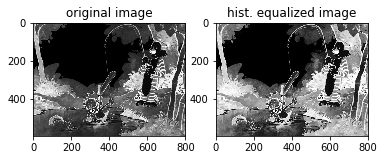

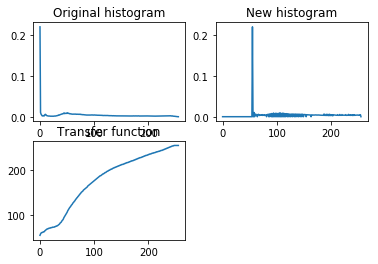

In [16]:
import pylab as plt
import matplotlib.image as mpimg
import numpy as np
# load image to numpy arrayb
# matplotlib 1.3.1 only supports png images
# use scipy or PIL for other formats
img = np.uint8(mpimg.imread('./img/calvin_hobbes.jpg')*255.0)
# convert to grayscale
# do for individual channels R, G, B, A for nongrayscale images

img = np.uint8((0.2126* img[:,:,0]) + \
  		np.uint8(0.7152 * img[:,:,1]) +\
			 np.uint8(0.0722 * img[:,:,2]))

# use hist module from hist.py to perform histogram equalization
new_img, h, new_h, sk = histeq(img)

# show old and new image
# show original image
plt.subplot(121)
plt.imshow(img)
plt.title('original image')
plt.set_cmap('gray')
# show original image
plt.subplot(122)
plt.imshow(new_img)
plt.title('hist. equalized image')
plt.set_cmap('gray')
plt.show()

# plot histograms and transfer function
fig = plt.figure()
fig.add_subplot(221)
plt.plot(h)
plt.title('Original histogram') # original histogram

fig.add_subplot(222)
plt.plot(new_h)
plt.title('New histogram') #hist of eqlauized image

fig.add_subplot(223)
plt.plot(sk)
plt.title('Transfer function') #transfer function

plt.show()

## Exercise 2.4: 
Image enchancement through filtering<br />

1. Load and show the original image **DONE**
2. Apply a smoothing filter **DONE**
3. Apply a sharpening filter  **DONE**
4. Illuminate from the southwest

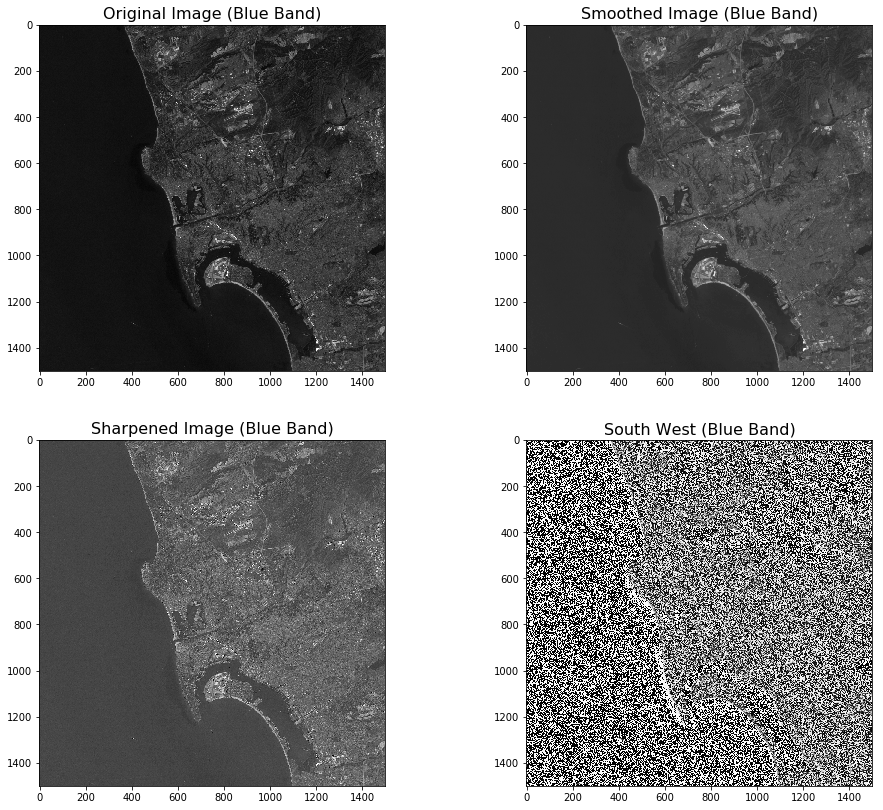

In [98]:
#plot_band_graysc(_plt, subplot_num, _data, title):
import scipy

def apply_smoothing_filter(_data):
    kernel = np.array([[1./9, 1./9, 1./9],[1./9, 1./9, 1./9],[1./9, 1./9, 1./9]])
    # Note: kernel should sum to 1

    # convolve 2d the kernel 
    smoothed = scipy.signal.convolve2d(_data, kernel, mode='same')
    return smoothed.astype(np.uint8)

def apply_sharpening_filter(_data):
    # make a sharpening filter using the kernel used to make a smoothing filter
    
    def _get_identity_operator(dim):
        m = np.zeros((dim, dim))
        m[m.shape[0]/2, m.shape[0]/2] = 1
        return m

    ii = _get_identity_operator(3)
    kernel = np.array([[1./9, 1./9, 1./9],[1./9, 1./9, 1./9],[1./9, 1./9, 1./9]])
   
    # p.285 in Rees 2nd Edition
    k=3
    new_kernel = k*ii + (1-k)*kernel
    #print new_kernel #looks fine
    sharpened = scipy.signal.convolve2d(_data, new_kernel, mode='same')
    return sharpened.astype(np.uint8)

def apply_sobel_filter_sw(_data):
    # illuminate from the southwest
    sobel_sw_kernel = np.array([[0, 1., 2.],[-1., 0, 1.],[-2., -1., 0]])
    illuminated = scipy.signal.convolve2d(_data, sobel_sw_kernel, mode='same')
    return illuminated.astype(np.uint8)
 
# blue band
bb = b1.astype(float)

plt.figure(figsize=(16,14))
plot_band_graysc(plt, 221, bb, 'Original Image (Blue Band)')
plot_band_graysc(plt, 222, apply_smoothing_filter(bb), 'Smoothed Image (Blue Band)')
plot_band_graysc(plt, 223, apply_sharpening_filter(bb), 'Sharpened Image (Blue Band)')
plot_band_graysc(plt, 224, apply_sobel_filter_sw(bb), 'South West (Blue Band)')
plt.show()